### **Setup**

In [6]:
os.getcwd()

'/data/private/Thesis/Trial'

In [1]:
import rasterio
import matplotlib.pyplot as plt
import os

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
# Set parameters
patch_size = 256
n_bands1 = 2
n_bands2 = 4
n_classes = 3
batch_size = 15
epochs = 5

#### Images and Labels

In [5]:
# Load image and label patches
#train1_x = np.load("Data/Patch_np/train1_xx.npy")
train2_x = np.load("Data/Patch_np/train2_xx.npy")
train_y = np.load("Data/Patch_np/train_yy.npy")

#test1_x = np.load("Data/Patch_np/test1_xx.npy")
test2_x = np.load("Data/Patch_np/test2_xx.npy")
test_y = np.load("Data/Patch_np/test_yy.npy")

In [21]:
#print(train1_x.shape)
print(train2_x.shape)
print(train_y.shape)
#print(test1_x.shape)
print(test2_x.shape)
print(test_y.shape)

(1291, 256, 256, 4)
(1291, 256, 256, 1)
(554, 256, 256, 4)
(554, 256, 256, 1)


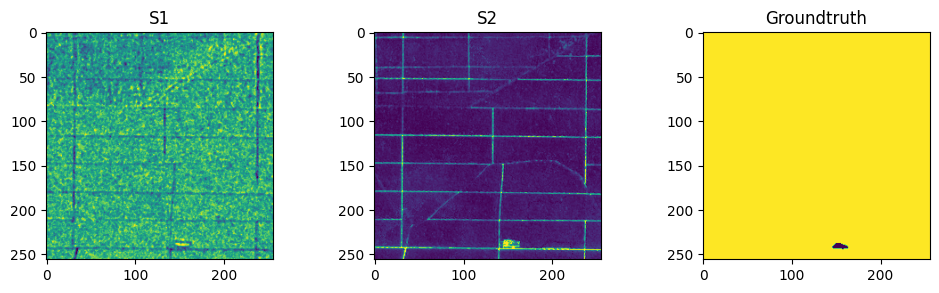

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))


axs[0].imshow(train1_x[723, :, :, 1])
axs[0].set_title("S1")
axs[1].imshow(train2_x[723, :, :, 2])
axs[1].set_title("S2")
axs[2].imshow(train_y[723, :, :, 0])
axs[2].set_title("Groundtruth")

plt.tight_layout()
plt.show()

In [6]:
train_y_1hot = tf.keras.utils.to_categorical(train_y)
test_y_1hot = tf.keras.utils.to_categorical(test_y)

train_y_1hot.shape

(1291, 256, 256, 3)

### **Building Model:** U-Net
With TensorFlow Keras Functional API

#### U-Net

In [23]:
# BN_CONV_ReLU,Pool: Biswas. #CONV_BN_ReLU,Pool: Chibber. #CONV_BN_ReLU,CONV_BN_ReLU,Dropout,Pool: Practical
# conv1 = tf.keras.layers.Conv2D(n_filters=64, kernel_size=3, dilation_rate=1, activation='relu', padding='same')
# https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
def get_model(patch_size, n_bands, n_classes):
    inputs = tf.keras.Input(shape=(patch_size, patch_size, n_bands))
    
    # ENCODER
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv4)

    # BOTTOM
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)
    
    # DECODER
    # BN_Conv2DTranspose_ReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_ReLU: Chibber. #Upsamling2D_CONV_BN_ReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)
    deconv4 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same')(conv5)
    merge4 = tf.keras.layers.concatenate([conv4, deconv4]) #order, axis=3
    uconv4 = tf.keras.layers.BatchNormalization()(merge4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)

    deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(uconv4)
    merge3 = tf.keras.layers.concatenate([conv3, deconv3])
    uconv3 = tf.keras.layers.BatchNormalization()(merge3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(uconv3)
    merge2 = tf.keras.layers.concatenate([conv2, deconv2])
    uconv2 = tf.keras.layers.BatchNormalization()(merge2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(uconv2)
    merge1 = tf.keras.layers.concatenate([conv1, deconv1])
    uconv1 = tf.keras.layers.BatchNormalization()(merge1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)

    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation="softmax")(uconv1)
    
    return tf.keras.Model(inputs, outputs)

Compile & Summarize Model

In [24]:
model = get_model(patch_size, n_bands2, n_classes) # Get model

# Compile as any Tensorflow model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
              
model.summary()

2023-02-21 13:46:48.280886: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

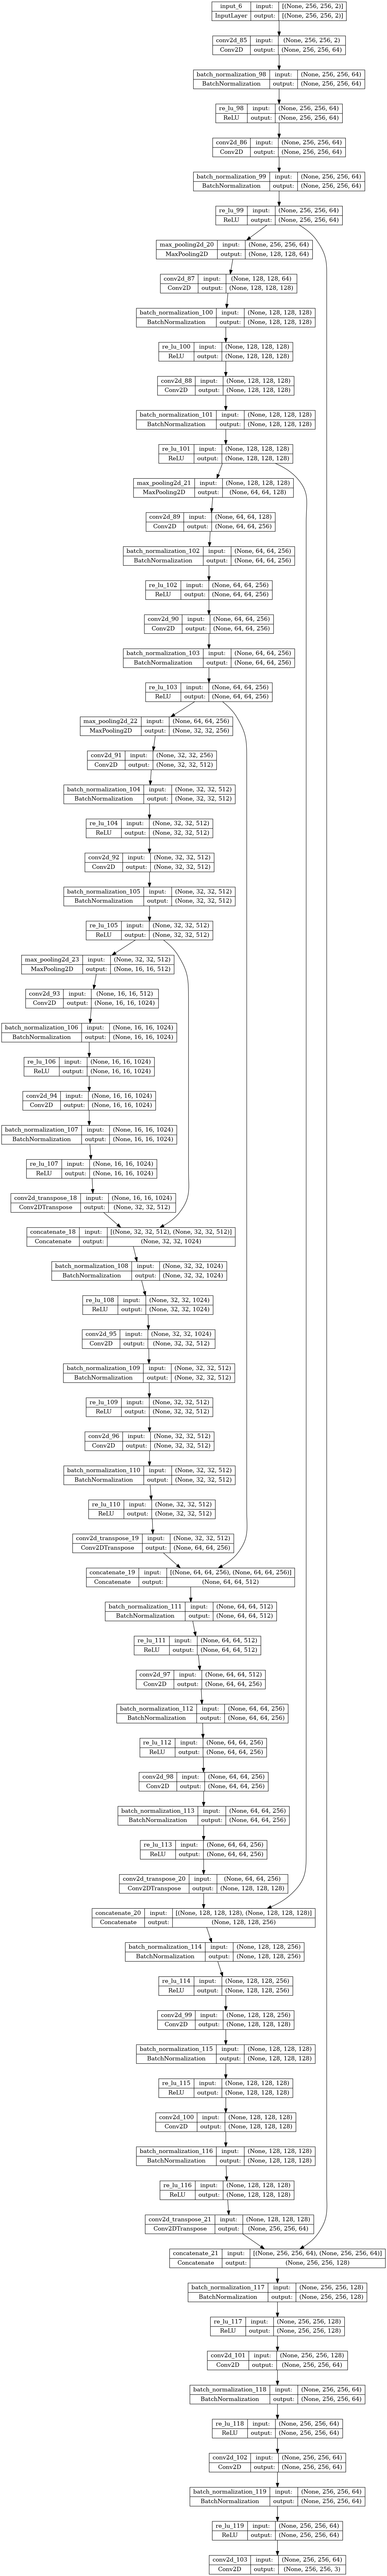

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

Train & Evaluate Model

In [25]:
# Define callbacks parameters
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [14]:
# Train and evaluate
history = model.fit(train2_x, train_y_1hot, batch_size=batch_size, epochs=epochs, #validation_split:0.2,
                    validation_data=(test2_x, test_y_1hot), callbacks=my_callbacks, verbose=1)

Epoch 1/5
87/87 [==============================] - 68s 630ms/step - loss: 0.8044 - accuracy: 0.6325 - val_loss: 2.9204 - val_accuracy: 0.4002
Epoch 2/5
87/87 [==============================] - 47s 546ms/step - loss: 0.6798 - accuracy: 0.7070 - val_loss: 1.4342 - val_accuracy: 0.3000
Epoch 3/5
87/87 [==============================] - 42s 482ms/step - loss: 0.6253 - accuracy: 0.7352 - val_loss: 4.9575 - val_accuracy: 0.3091
Epoch 4/5
87/87 [==============================] - 54s 618ms/step - loss: 0.5672 - accuracy: 0.7655 - val_loss: 1.2842 - val_accuracy: 0.3805
Epoch 5/5
87/87 [==============================] - 48s 548ms/step - loss: 0.5531 - accuracy: 0.7700 - val_loss: 1.0938 - val_accuracy: 0.4045


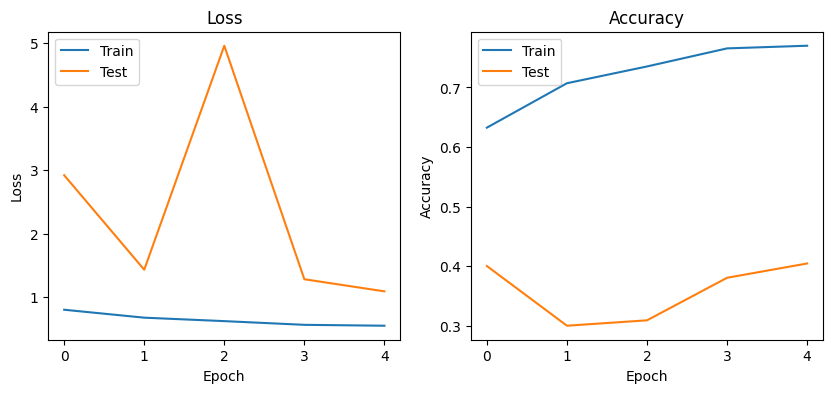

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

#plt.tight_layout()
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(test2_x, test_y_1hot)
print(f"\nValidation accuracy of U-Net: {100 * test_acc:.2f}%")

18/18 [==============================] - 5s 247ms/step - loss: 1.0938 - accuracy: 0.4045

Validation accuracy of U-Net: 40.45%


Save Model Weights

In [ ]:
# https://stackoverflow.com/questions/51854463/is-it-possible-to-retrain-a-previously-saved-keras-model
model.save("unet_weight.h5")
#model.save_weights("unet_weights.h5")

## Load Back Model

In [4]:
# Load pretrained model
reconstructed_model = tf.keras.models.load_model("Output/model.05-1.09.h5")
model = reconstructed_model

2023-02-21 16:16:08.758405: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


## Apply Model to Predict Random Patches

1/1 [==============================] - 0s 55ms/step


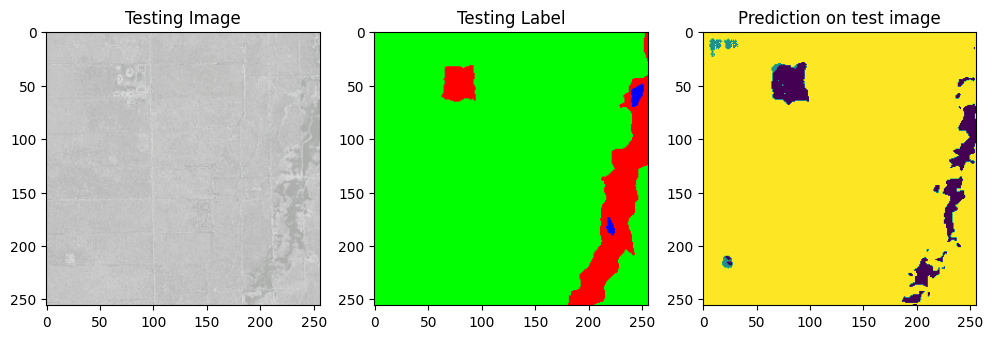

In [11]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(test2_x))
test_img = test2_x[test_img_number]
ground_truth=test_y_1hot[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Apply Model to Predict Whole Scene

In [12]:
# Load image
#with rasterio.open("Data/Crop/S1.tif") as src:
#    s1 = src.read()
with rasterio.open("Data/Crop/S2.tif") as src:
    s2 = src.read()
with rasterio.open("Data/Crop/Label.tif") as src:
    label = src.read()

In [6]:
s2_img = np.transpose(s2, (1,2,0))
print(s2_img.shape)

(11460, 11570, 4)


In [7]:
def pad_image_to_patch_size(image, patch_size=patch_size):
    height, width, depth = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = np.zeros((target_height, target_width, depth))
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)

In [8]:
def apply_segmentation_with_fcn(image, fcn, patch_size=patch_size, step=patch_size//2):
    original_height, original_width, _ = image.shape
    padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    height, width, _ = padded.shape
    
    predictions = np.zeros((height, width, n_classes))
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = padded[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = fcn.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            predictions[row:row + patch_size, col:col + patch_size, :] += \
                row_predictions[patch_idx]
            col += step
            patch_idx += 1

        row += step

    predictions = predictions[
        pad_height:pad_height + original_height,
        pad_width:pad_width + original_width, :
    ]
    predictions = np.argmax(predictions, axis=-1)
    
    return predictions

In [9]:
# Classify image
prediction = apply_segmentation_with_fcn(s2_img, model)

In [11]:
label_ = np.transpose(label, (1,2,0))
print(label_.shape)

(11460, 11570, 1)


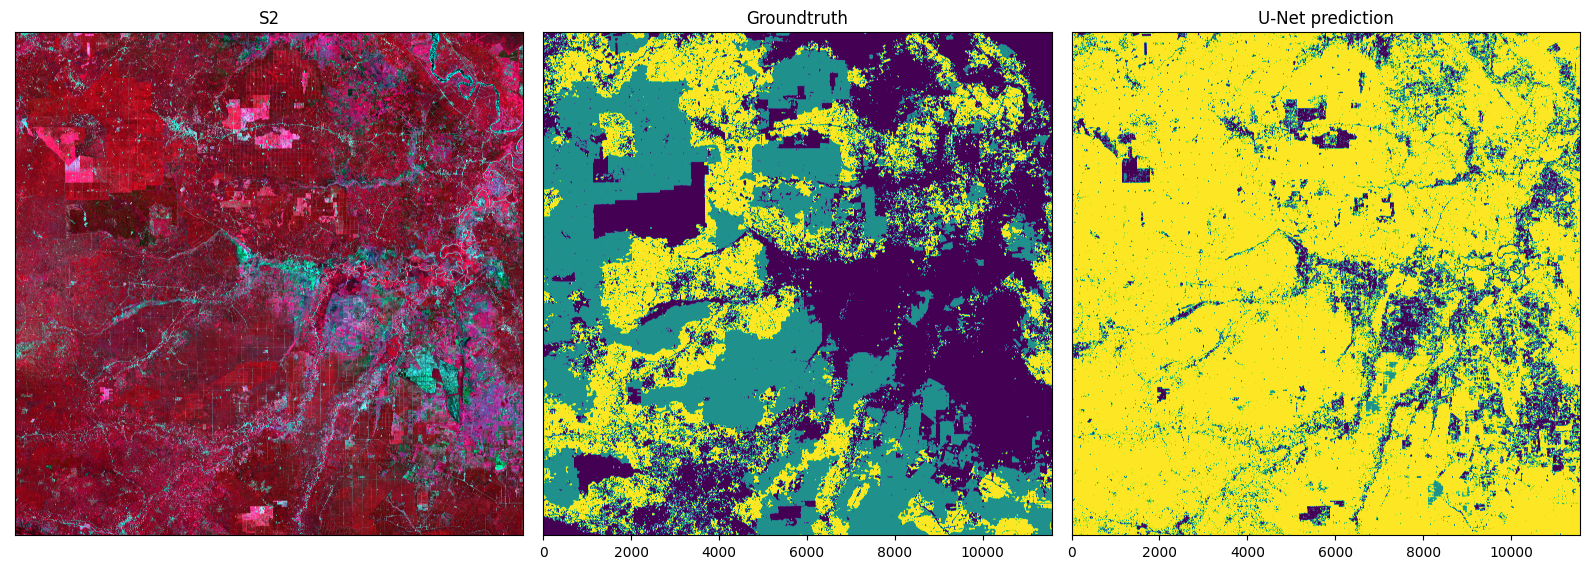

In [18]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7), sharey=True)

axs[0] = ep.plot_rgb(s2, rgb=(3, 2, 1), ax=axs[0], stretch=True, title="S2",)
#axs[0].imshow(s2_img[:, :, [2, 1, 0]])
#axs[0].set_title("Satellite image")
axs[1].imshow(label_[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()

In [ ]:
# Export
with rasterio.open("Data/Crop/Label.tif") as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['dtype'] = "int8"
#ras_meta['nodata'] = -99

with rasterio.open('pred4.tif', 'w', **ras_meta) as dst:
    dst.write(prediction, 1)